In [1]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
import os, shutil
import numpy as np
import keras 
from keras.models import load_model
import keras.layers as layers
from segmentation_models import Unet
import matplotlib.pyplot as plt

from keras.layers import Activation, Dense
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

def swish(x):
        return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ign1/anaconda3/envs/pruebas/lib/python3.7/s

Segmentation Models: using `keras` framework.



In [2]:
model = load_model('models1/Unet-inceptionResNet-3.h5', compile=False)

In [3]:
from segmentation_models import Unet
from keras.optimizers import Adam
import segmentation_models as sm
from segmentation_models.losses import bce_jaccard_loss, bce_dice_loss
model.compile(optimizer = Adam(),loss=bce_jaccard_loss, metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
from keras.utils import Sequence
from skimage.io import imread
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np

tf.logging.set_verbosity(tf.logging.ERROR)
%load_ext autoreload
%autoreload 2
%matplotlib inline
from albumentations import (Blur, Compose, HorizontalFlip, HueSaturationValue,
                            IAAEmboss, IAASharpen, JpegCompression, OneOf,
                            RandomBrightness, RandomBrightnessContrast,
                            RandomContrast, RandomCrop, RandomGamma,
                            RandomRotate90, RGBShift, ShiftScaleRotate,
                            Transpose, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion)
 
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray.reshape((1024,1024,1))

def listdir_fullpath(d):
    return [os.path.join(d, f) for f in os.listdir(d)]


def removeAlphaChannel(image):
    return image[:,:,:3]

import albumentations as albu
from albumentations import Resize

class DataGeneratorFolder(Sequence):
    def __init__(self, root_dir=r'../data/val_test', image_folder='img/', mask_folder='masks/', 
                 batch_size=1, image_size=1024, nb_y_features=1, 
                 augmentation=None,
                 suffle=True):
        self.image_filenames = listdir_fullpath(os.path.join(root_dir, image_folder))
        self.mask_names = listdir_fullpath(os.path.join(root_dir, mask_folder))
        self.batch_size = batch_size
        self.currentIndex = 0
        self.augmentation = augmentation
        self.image_size = image_size
        self.nb_y_features = nb_y_features
        self.indexes = None
        self.suffle = suffle
        
    def __len__(self):
        """
        Calculates size of batch
        """
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.suffle==True:
            self.image_filenames, self.mask_names = shuffle(self.image_filenames, self.mask_names)
        
    def read_image_mask(self, image_name, mask_name):
        #return removeAlphaChannel(imread(image_name))/255, rgb2gray(imread(mask_name)).astype(np.int8)
        return (removeAlphaChannel(imread(image_name))/255).astype(np.float32), (imread(mask_name, as_gray=True)<1).astype(np.int8)
 
    def __getitem__(self, index):

            # Generate indexes of the batch
            data_index_min = int(index*self.batch_size)
            data_index_max = int(min((index+1)*self.batch_size, len(self.image_filenames)))

            indexes = self.image_filenames[data_index_min:data_index_max]

            this_batch_size = len(indexes) # The last batch can be smaller than the others

            # Defining dataset
            X = np.empty((this_batch_size, self.image_size, self.image_size, 3), dtype=np.float32)
            y = np.empty((this_batch_size, self.image_size, self.image_size, self.nb_y_features), dtype=np.uint8)

            for i, sample_index in enumerate(indexes):            
                X_sample, y_sample = self.read_image_mask(self.image_filenames[index * self.batch_size + i], self.mask_names[index * self.batch_size + i])


                # if augmentation is defined, we assume its a train set

                if self.augmentation is not None:

                    # Augmentation code
                    a = self.augmentation(image_size=self.image_size)
                    augmented = a(image=X_sample, mask=y_sample)
                    image_augm = augmented['image']
                    #image_augm = X_sample
                    mask_augm = augmented['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
                    #mask_augm = y_sample.reshape(self.image_size, self.image_size, self.nb_y_features)
                    X[i, ...] = np.clip(image_augm, a_min = 0, a_max=1)
                    y[i, ...] = mask_augm

                # if augmentation isnt defined, we assume its a test set. 
                # Because test images can have different sizes we resize it to be divisable by 32
                elif self.augmentation is None and self.batch_size == 1:
                    X_sample, y_sample = self.read_image_mask(self.image_filenames[index * 1 + i], 
                                                          self.mask_names[index * 1 + i])
                    #augmented = Resize(height=(X_sample.shape[0]//32)*32, width=(X_sample.shape[1]//32)*32)(image = X_sample, mask = y_sample)
                    #X_sample, y_sample = augmented['image'], augmented['mask']

                    return X_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], 3).astype(np.float32),\
                           y_sample.reshape(1, X_sample.shape[0], X_sample.shape[1], self.nb_y_features).astype(np.uint8)

            return X, y

In [9]:
import cv2 as cv
test_generator = DataGeneratorFolder(root_dir = './test',
                           image_folder = 'input/',
                           mask_folder = 'output/',
                                   batch_size=1,
                                   nb_y_features = 1, augmentation = None,suffle=False)

In [10]:
def iou_metric(y_true_in, y_pred_in):
    labels = y_true_in
    y_pred = y_pred_in

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    iou = intersection / union
    return iou


def plot_mask_gt_image(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(20,10))
    axs[0].imshow(mask, cmap="Blues")
    axs[1].imshow(groud_truth, cmap="Blues")
    axs[2].imshow(img)
    plt.show()
    
def iou_metric_batch(y_true_in, y_pred_in):
    y_pred_in = y_pred_in
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [11]:
scores = model.evaluate_generator(test_generator)
metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()]
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))  

Loss: 1.3416
mean iou_score: 0.32116
mean f1-score: 0.43955


IOU [[0.79056616]]


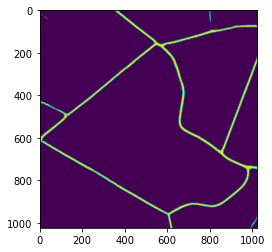

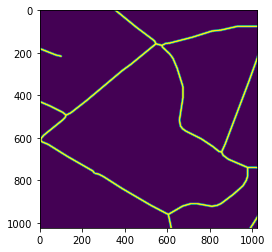

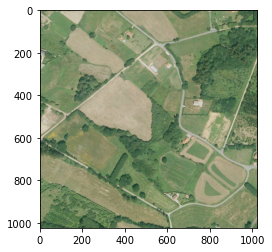

In [8]:
#OBTENER IMAGENES CON RESULTADOS:
Xtest, y_test  = test_generator.__getitem__(30) #PROBAR DIFERENTES ITEMS: ej, 25, 30, 1000, 30000 (para obtener diferentes resultados)
predicted = model.predict(np.expand_dims(Xtest[0], axis=0)).reshape(1024, 1024)
print('IOU', iou_metric(y_test[0].reshape(1024, 1024), predicted))

plt.imshow(predicted)
plt.show()
plt.imshow(y_test[0].reshape((1024,1024)))
plt.show()
plt.imshow(Xtest[0])
plt.show()
